In [3]:
import oommfc as mc
import discretisedfield as df
import micromagneticmodel as mm
import random
import numpy as np
import numbers
import matplotlib.pyplot as plt
import pandas as pd
md = mc.MinDriver()
hd = mc.HysteresisDriver()
random.seed(2) #Con esto aseguramos reproducibilidad

In [35]:
#Defimos funciones para crear una subregion.
#xmin es el punto minimo en x de la subregion
#ymin es el punto minimo en y de la subregion
#zmin es el punto minimo en z de la subregion
#xmin es el punto maximo en x de la subregion
#ymin es el punto maximo en y de la subregion
#ymin es el punto maximo en y de la subregion
#subregions es una diccionario en la cual se guarda la subregion creada
#i es el número de la subregión creada
#Devuelve la subregion creada para un xmin,ymin,zmin,xmax,ymax y zmax dados.
def subreg(xmin,xmax,ymin,ymax,zmin,zmax,subregions,i):
    #Punto minimo de la subregion
    p1 = (xmin, ymin, zmin)
    #Punto maximo de la subregion
    p2 = (xmax, ymax, zmax)
    #Creacion de la region con discretisedfield
    region1 = df.Region(p1=p1, p2=p2)
    #Nombre de la región
    r='region{}'.format(i)
    #Se guarda la subregion
    subregions[r] = region1
    #Devuelve la subregion guardada
    return subregions

#Funcion para una region de 3 capas
#Recibe como parametro los valores minimos en los ejes x,y,z de la región en general
#Recibe como parametro el espesor del material no magnetico y el espesor del material magnetico
#Recibe como parametro "celda", la cual define en cuantos cuadros se puede dividir la region. Por definicion es 0.25nm
#  pero se puede modificar
#La función devuelve la tricapa y las subregiones creadas.
def region(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,celda=0.5e-9):  
    #Para la region 1
    xmin1=xminr
    ymin1=yminr
    zmin1=zminr
    zmax1=espesor_ferromagnetico

    #Para la region 2
    xmin2=xminr
    ymin2=yminr
    zmin2=zmax1 
    zmax2=zmin2 + espesor_no_magnetico
    
    #Para la region 3 
    xmin3=xminr
    ymin3=yminr
    zmin3=zmax2
    zmax3=zmin3 + espesor_ferromagnetico
    zmaxr=zmax3
    
    #Maximo region en general
    xmaxr=espesor_ferromagnetico
    ymaxr=espesor_ferromagnetico
    
    #Maximos en region 1
    xmax1=xmaxr
    ymax1=ymaxr
     
    #Maximos en region 2
    xmax2=xmaxr
    ymax2=ymaxr
     
    #Maximos en region 3
    xmax3=xmaxr
    ymax3=ymaxr
    
    #defino una diccionario vacio para las subregiones
    subregions={}
    
    #Creo cada una de las subregiones
    subregions=subreg(xmin1,xmax1,ymin1,ymax1,zmin1,zmax1,subregions,1)
    subregions=subreg(xmin2,xmax2,ymin2,ymax2,zmin2,zmax2,subregions,2)
    subregions=subreg(xmin3,xmax3,ymin3,ymax3,zmin3,zmax3,subregions,3)
    
    #Tamaño de la celda
    cell=(celda,celda,celda)
    
    #Creo el mesh
    mesh = df.Mesh(p1=(xminr, yminr, zminr), p2=(xmaxr, ymaxr, zmaxr),cell=cell, subregions=subregions)
   
    return mesh,subregions

#Función para definir la energía del sistema
#A es la energia de intercambio
#K es la constante de anisotropía
#H el campo aplicado[A/m]
#Devuelve la energia del sistema
def energia_del_sistema(A,K,sigma,sigma2,subregs,H=(0,0,0)):
    #easy axis
    u=(1,0,0)
    #Energias del sistema
    E_exchange=mm.Exchange(A=A)
    E_Zeeman=mm.Zeeman(H=H)
    E_Uniaxial_Anisotropy= mm.UniaxialAnisotropy(K=K, u=u)
    E_rkky=mm.RKKY(sigma=sigma, sigma2=sigma2, subregions=subregs)
    Demag=mm.Demag()
    # Defino el Hamiltoniano del sistema
    E= E_Zeeman  + E_exchange +E_Uniaxial_Anisotropy + E_rkky + Demag 
    return E

#Funcion para la energia del sistema entre dos FM
#Recibe como parametro los valores minimos en los ejes x,y,z de la región en general
def grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado):
    #Dibujo la primera región
    mesh,subregions=region(xminr,yminr,zminr,espesor_ferromagnetico,espesor_no_magnetico)
    #Subregiones para el primer material FM (region1) y el segundo FM(region3). region2 es la region donde se ubica el material no magnetico.
    subregs=['region1', 'region3']
    #Norma de para definir la magnetizacion inicial
    norm = {'region1': Ms, 'region3': Ms, 'region2': 0}
    #Valores de la energia de intercambio para distintas regiones
    A_ = {'region1' : A  , 'region3':A, 'region2' :0}
    #Valores de la energia anisotropica para distintas regiones
    K_ = {'region1': K,'region3': K, 'region2': 0}
    #Defino la energina del sistema
    system = mm.System(name='Energia')
    system.energy=energia_del_sistema(A_,K_,sigma,sigma2,subregs)
    #Funcion para generar espines aleatorios
    def m_fun(pos):
        return [2 * random.random() - 1 for i in range(3)]
    #Se establece el sistema inicial con la energia y la magnetizacion inicial.
    system.m = df.Field(mesh, dim=3,  value=m_fun, norm=norm)
    #print('antes')
    
    #Para observar la configuracion de espines antes de minimizar la energía dle sistema
    system.m.plane('y').mpl()
    #Se minimiza la energía del sistema
    md.drive(system)    
    #print('después')
    #Para observar la configuracion de espines despues de minimizar la energía dle sistema
    system.m.plane('y').mpl()

    #Aplicamos un campo magnetico externo (A/m)    
    Hz_vacio=campo_aplicado/mm.consts.mu0
    #Vector campo aplicado para un valor minimo y maximo
    Hmin=(0,-Hz_vacio,0)
    Hmax=(0,Hz_vacio,0)
    #numero de ciclos que hace el programa
    n=85
    #Realización de la curva de histéresis
    hd.drive(system, Hmin=Hmin, Hmax=Hmax, n=n)
    #Se observan los espines desúes de finalizar la curva
    system.m.plane('y').mpl()
    return system

#Función para guardar los datos obtenidos de la curva de histeresis
#systema es el sistema que estamos guardando
#nombre es el nombre del archivo donde se guardarán los datos
#No devuelve nada
def guardar_datos(systema,nombre):
    #Campo magnetico en el eje y [mT]
    By_hysteresis=systema.table.data['By_hysteresis']
    #Magnetización del sistema
    my=systema.table.data['my']
    #Energía total del sistema
    E_t=systema.table.data['E'] 
    #Energía RKKY
    E_rkky=systema.table.data['E_rkky']
    #nombre del archivo
    n=nombre + '.txt'
    #Se crea el archivo y se escribe en este
    f=open(n,'w')
    f.write('By_hysteresis;my;ERKKY;E\n')
    for i in range(len(my)):
        f.write('{};{};{};{}\n'.format(By_hysteresis[i],my[i],E_rkky[i],E_t[i]))
    #Se cierra el archivo    
    f.close()

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/28 13:11]... (19.9 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/28 13:11]... (408.5 s)


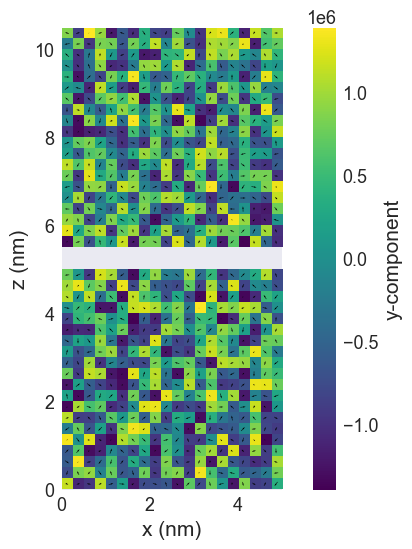

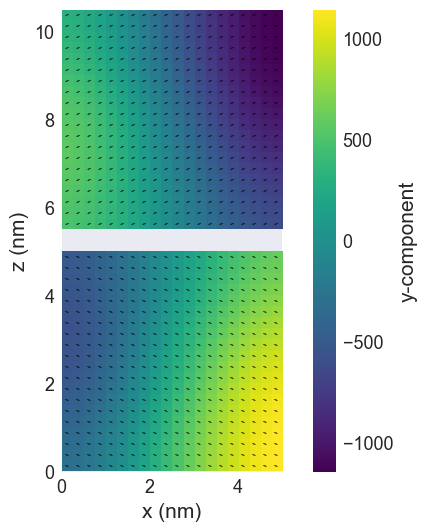

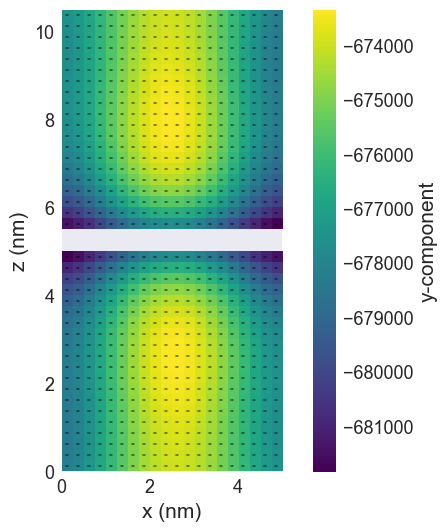

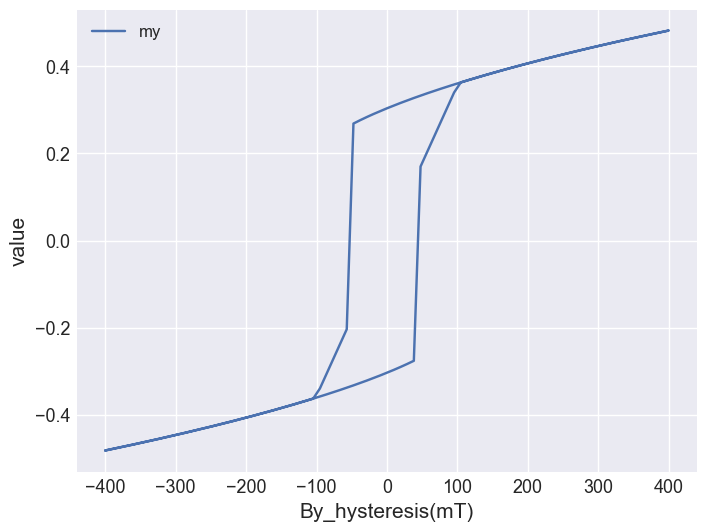

In [15]:
#Parametros de la region en general. Inicio la region en cero
xminr=0
yminr=0
zminr=0
#Energia de intercambio para el Cobalto 
A=30e-12
#Constante de anisotropía
K=5.2e5
#Saturación de magnetización para el Cobalto
Ms=1.4e6 #A/m

sigma=-np.sqrt(A*K/2)
sigma2=sigma

#Campo aplicado. Viene dado en teslas
campo_aplicado=0.4#T

#Espesores para el Cobalto y Niobio respectivamente
espesor_ferromagnetico=5e-9
espesor_no_magnetico=0.5e-9
system1=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system1.table.mpl(x='By_hysteresis', y=['my'])

In [36]:
guardar_datos(system1,'0_5')

In [27]:
min(abs(system1.table.data['By_hysteresis']))

0.0

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/28 14:03]... (22.3 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/28 14:04]... (379.4 s)


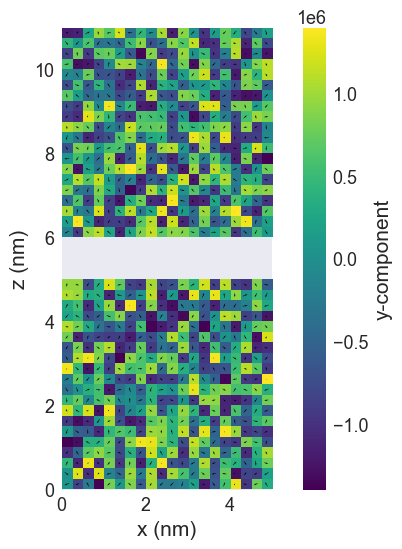

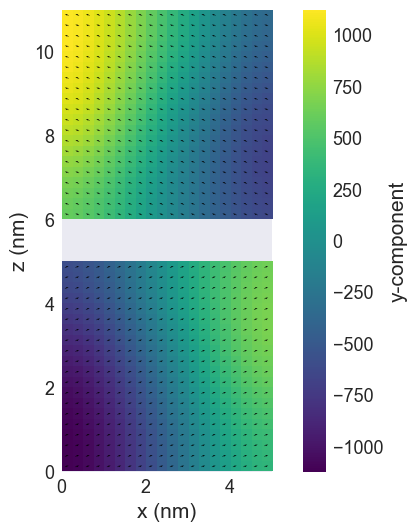

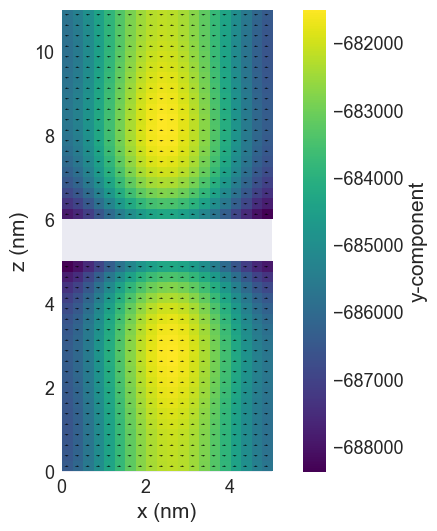

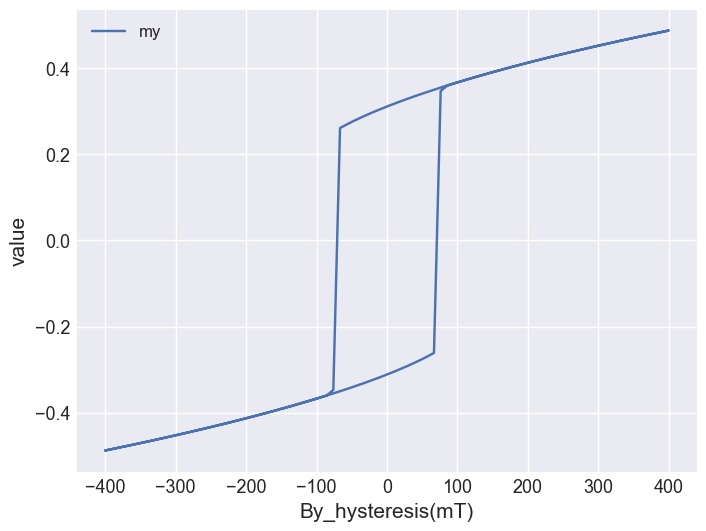

In [17]:
espesor_no_magnetico=1e-9


system2=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system2.table.mpl(x='By_hysteresis', y=['my'])

In [37]:
guardar_datos(system2,'1nm')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/28 14:10]... (18.6 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/28 14:10]... (251.0 s)


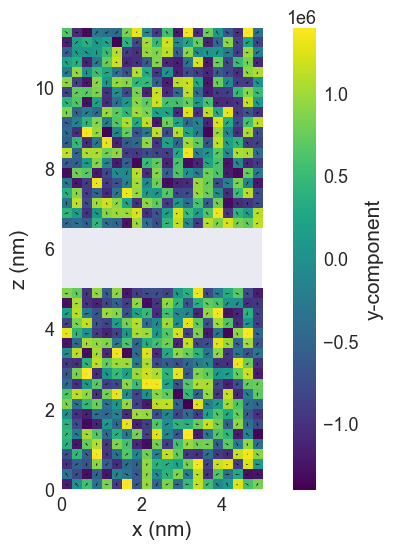

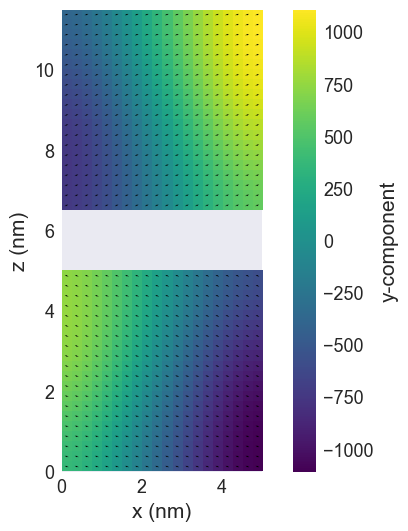

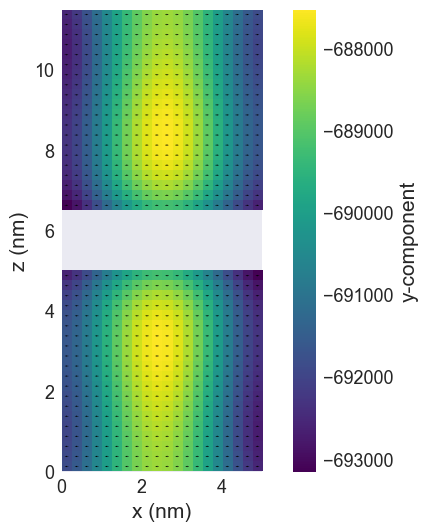

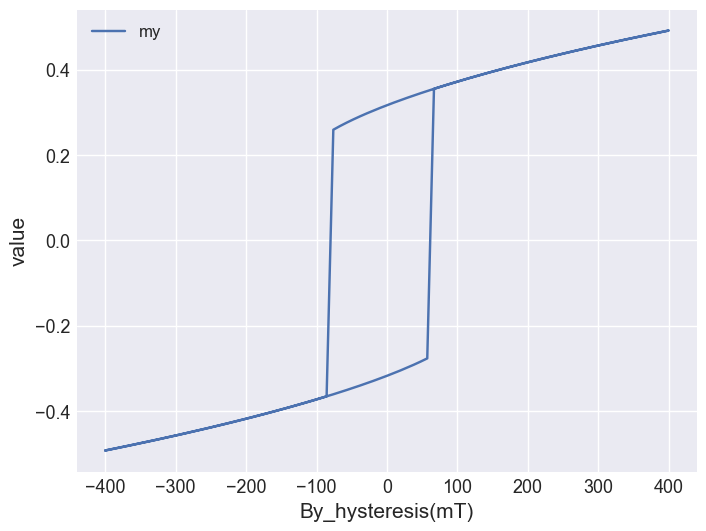

In [19]:
espesor_no_magnetico=1.5e-9
system3=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system3.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system3,'1_5')

In [38]:
guardar_datos(system3,'1_5')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/28 14:15]... (15.3 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/28 14:15]... (209.2 s)


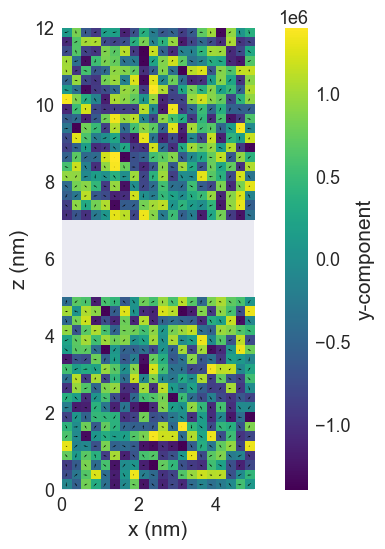

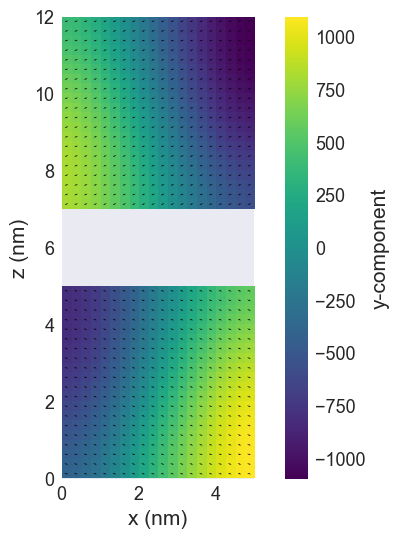

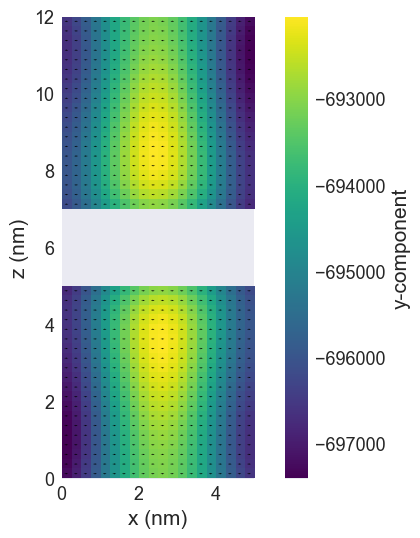

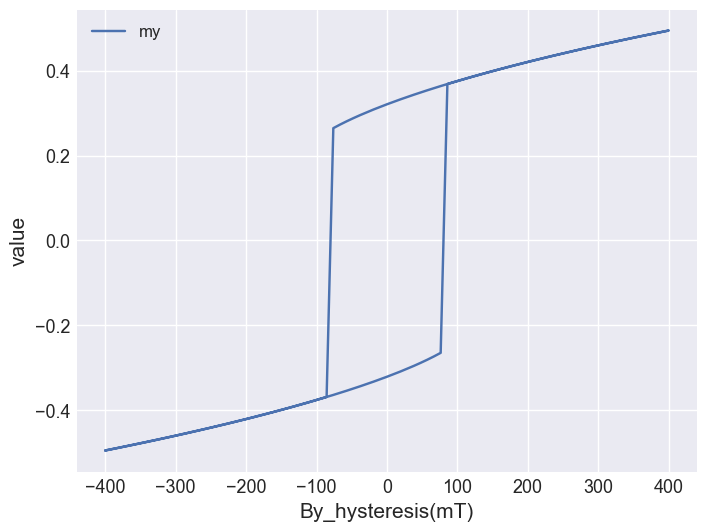

In [21]:
espesor_no_magnetico=2e-9
system4=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system4.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system4,'2')

In [39]:
guardar_datos(system4,'2')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/28 14:18]... (23.3 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/28 14:19]... (363.6 s)


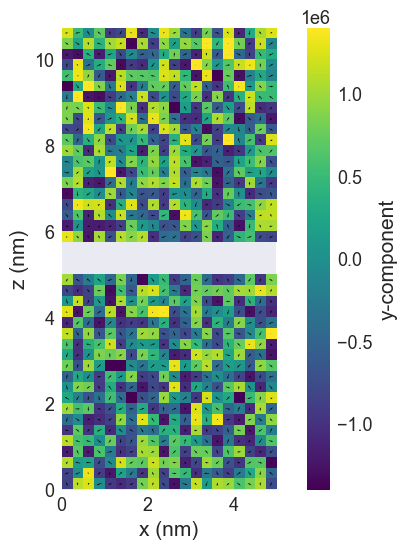

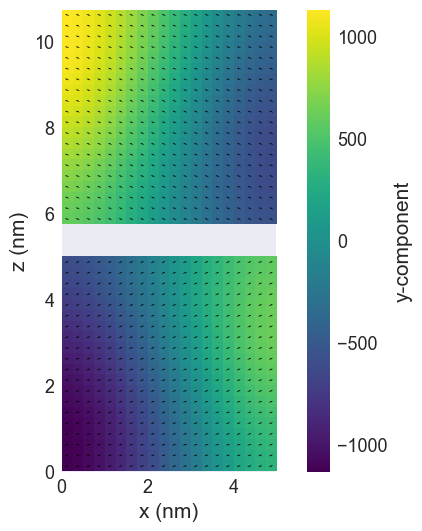

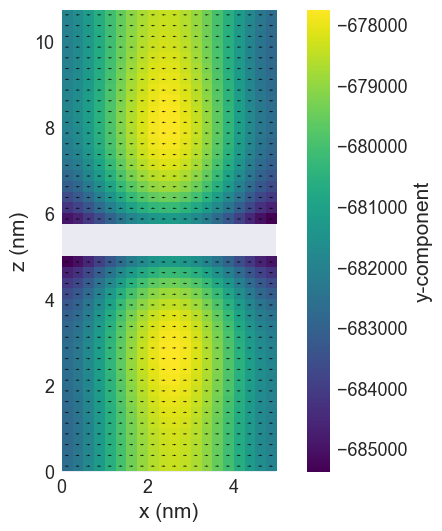

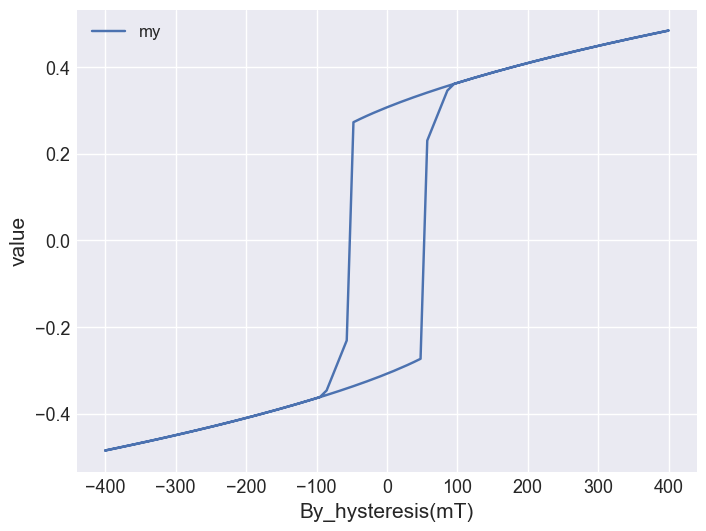

In [23]:
espesor_no_magnetico=0.75e-9
system5=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system5.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system5,'0_75')

In [40]:
guardar_datos(system5,'0_75')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/28 18:57]... (517.6 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/28 19:06]... (6187.2 s)


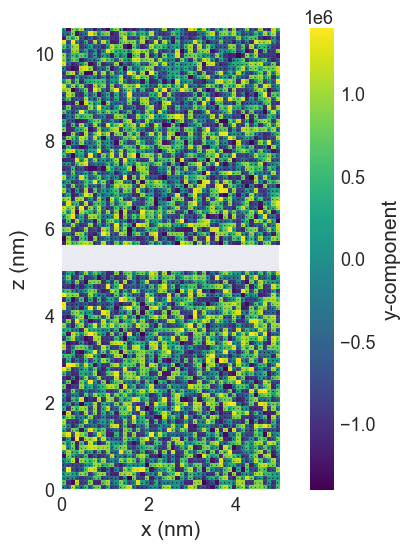

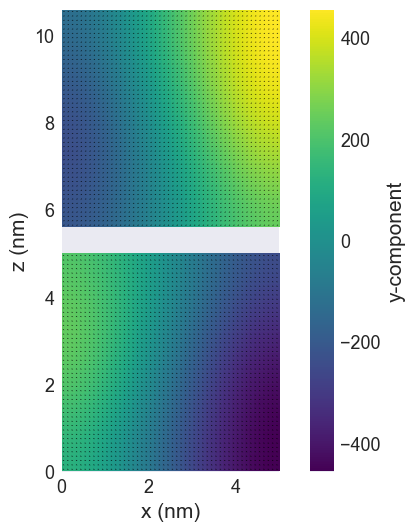

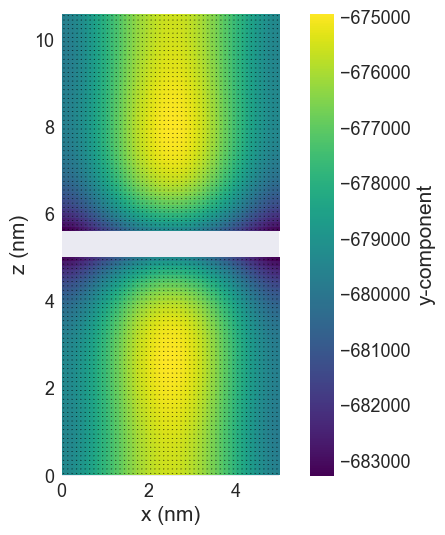

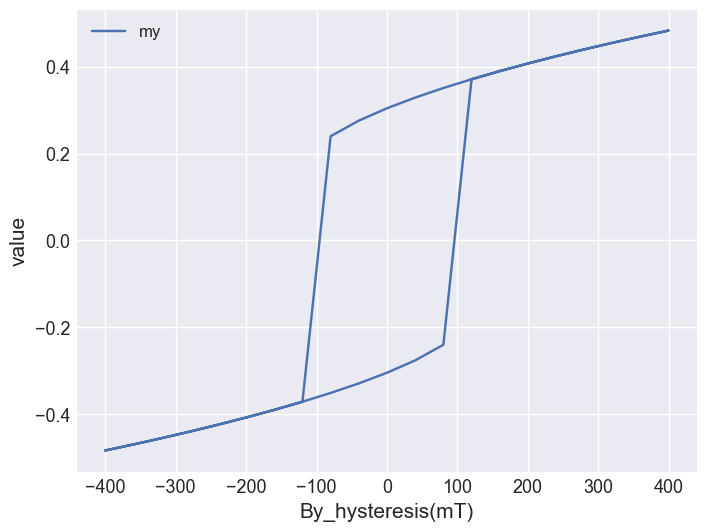

In [43]:
#Funcion para una region de 3 capas
def region(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,celda=0.1e-9):  
    
    #Para la region 1
    xmin1=xminr
    ymin1=yminr
    zmin1=zminr

    zmax1=espesor_ferromagnetico
    
    #Para la region 2
    xmin2=xminr
    ymin2=yminr
    zmin2=zmax1 
    
    
    zmax2=zmin2 + espesor_no_magnetico
    
     #Para la region 3
    
    xmin3=xminr
    ymin3=yminr
    zmin3=zmax2
    
    
    zmax3=zmin3 + espesor_ferromagnetico
    zmaxr=zmax3
    
    xmaxr=5e-9
    ymaxr=5e-9
    
    #R1
    xmax1=xmaxr
    ymax1=ymaxr
     
     #R2
    xmax2=xmaxr
    ymax2=ymaxr
     
     #R3
    xmax3=xmaxr
    ymax3=ymaxr
    
    #defino una lista vacia para las subregiones
    subregions={}
    
    #Creo cada una de las subregiones
    subregions=subreg(xmin1,xmax1,ymin1,ymax1,zmin1,zmax1,subregions,1)
    
    subregions=subreg(xmin2,xmax2,ymin2,ymax2,zmin2,zmax2,subregions,2)
    
    subregions=subreg(xmin3,xmax3,ymin3,ymax3,zmin3,zmax3,subregions,3)
    
    cell=(celda,celda,celda)
    
    #Creo el mesh
    mesh = df.Mesh(p1=(xminr, yminr, zminr), p2=(xmaxr, ymaxr, zmaxr),cell=cell, subregions=subregions)
   
    return mesh,subregions

#Funcion para la energia del sistema entre dos FM

def grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado):
   
    #Dibujo la primera región
    mesh,subregions=region(xminr,yminr,zminr,espesor_ferromagnetico,espesor_no_magnetico)
    
    
    #Donde r1 es el primer material FM, r2 para el NM y r3 para el FM
    subregs=['region1', 'region3']
    
    
   
    #Norma de para definir la magnetizacion inicial
    norm = {'region1': Ms, 'region3': Ms, 'region2': 0}
    
    #Valores de la energia de intercambio para distintas regiones
    A_ = {'region1' : A  , 'region3':A, 'region2' :0}
    

    K_ = {'region1': K,'region3': K, 'region2': 0}
    

     #Defino la energina del sistema
    system = mm.System(name='Energia')
 
    system.energy=energia_del_sistema(A_,K_,sigma,sigma2,subregs)
    #system.dynamics=mm.Damping(alpha=alpha) #+ mm.Precession(gamma0=gamma0)
    #Inicialmente
    #system.m = df.Field(mesh, dim=3, value=lambda point: [2*random.random()-1 for i in range(3)], norm=norm)
    def m_fun(pos):
        return [2 * random.random() - 1 for i in range(3)]
    #system.m = df.Field(mesh, dim=3,  value=(1,0,0) , norm=norm)
    system.m = df.Field(mesh, dim=3,  value=m_fun, norm=norm)
    print('antes')
    #create system with above geometry and initial magnetisation
    #system.m = df.Field(mesh, dim=3,  m_fun, norm=norm) # define initial magnetisation
    system.m.plane('y').mpl()
    
    md.drive(system)    
    print('después')
    system.m.plane('y').mpl()
    print('voy 2')
    #Aplicamos un campo magnetico externo (A/m)    
        
    Hz_vacio=campo_aplicado/mm.consts.mu0
    Hz_Co=campo_aplicado/(250*mm.consts.mu0)
    
    Hmin=(0,-Hz_vacio,0)
    Hmax=(0,Hz_vacio,0)
    n=21
    hd.drive(system, Hmin=Hmin, Hmax=Hmax, n=n)
    system.m.plane('y').mpl()

    return system


espesor_no_magnetico=0.6e-9
system6=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system6.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system6,'0_6')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/28 21:38]... (497.9 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/28 21:46]... (7942.5 s)


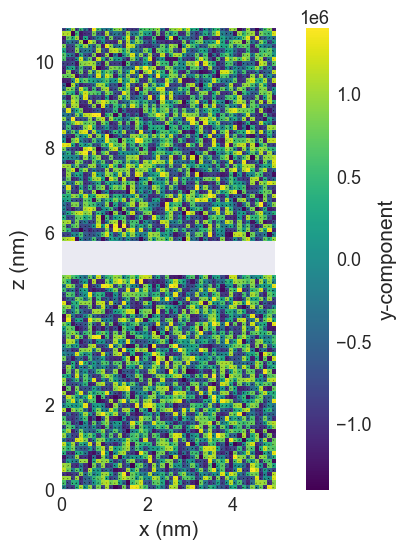

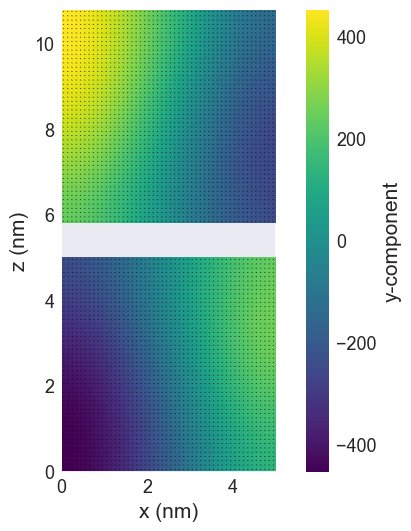

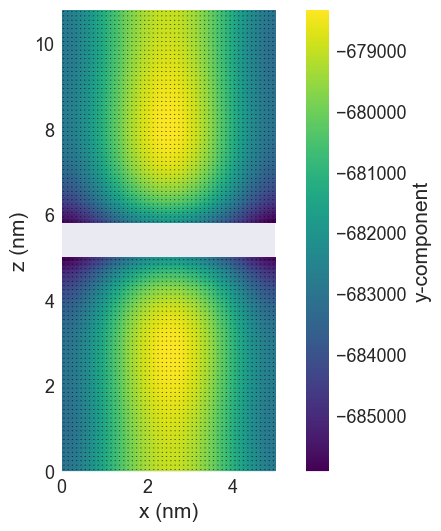

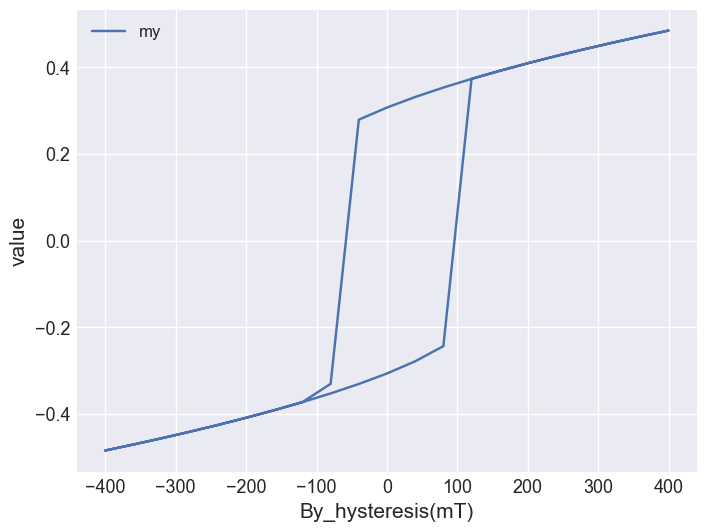

In [44]:

espesor_no_magnetico=0.8e-9
system7=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system7.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system7,'0_8')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/28 23:59]... (440.4 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/29 00:06]... (9944.6 s)


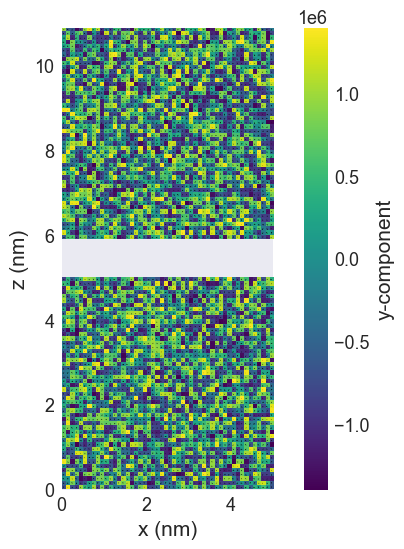

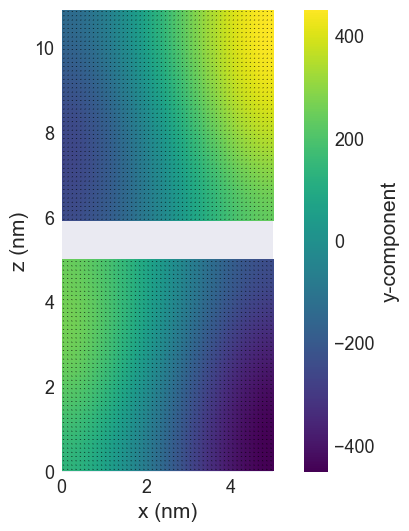

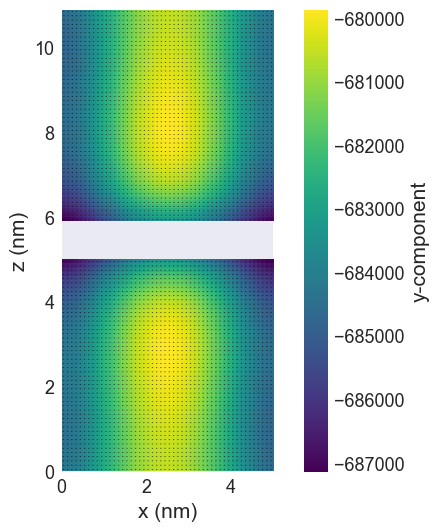

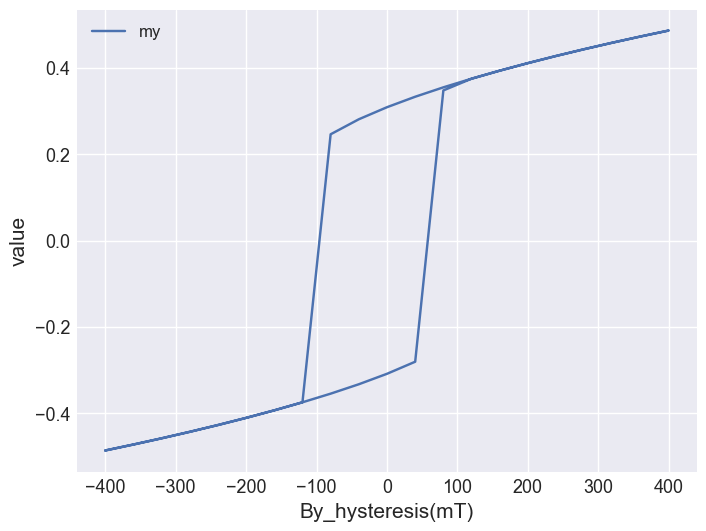

In [45]:

espesor_no_magnetico=0.9e-9
system8=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system8.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system8,'0_9')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/29 08:02]... (23.8 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/29 08:02]... (137.1 s)


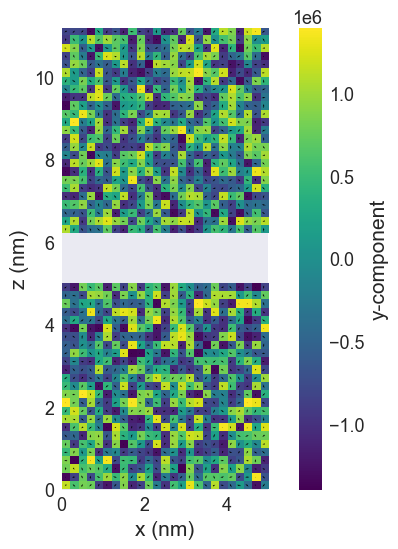

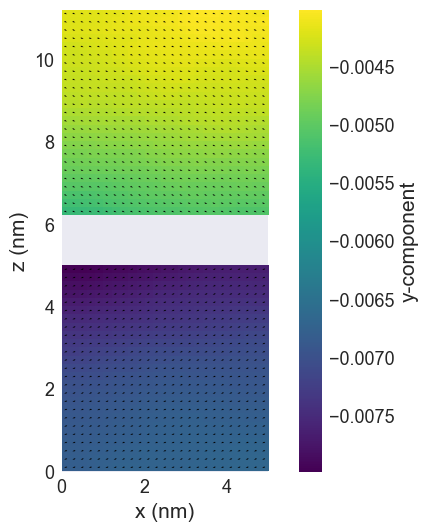

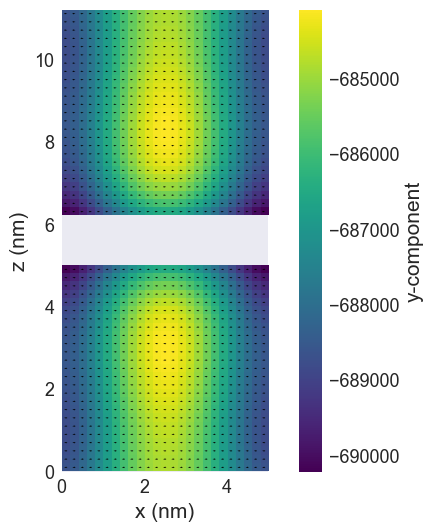

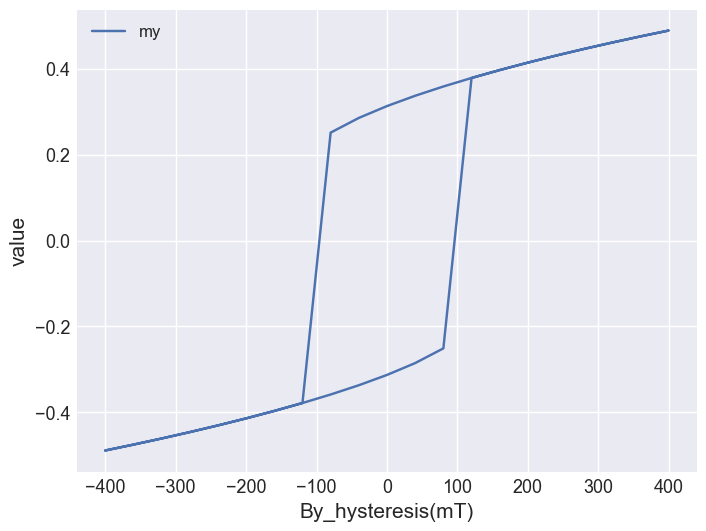

In [49]:
#Funcion para una region de 3 capas
def region(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,celda=0.2e-9):  
    
    #Para la region 1
    xmin1=xminr
    ymin1=yminr
    zmin1=zminr

    zmax1=espesor_ferromagnetico
    
    #Para la region 2
    xmin2=xminr
    ymin2=yminr
    zmin2=zmax1 
    
    
    zmax2=zmin2 + espesor_no_magnetico
    
     #Para la region 3
    
    xmin3=xminr
    ymin3=yminr
    zmin3=zmax2
    
    
    zmax3=zmin3 + espesor_ferromagnetico
    zmaxr=zmax3
    
    xmaxr=5e-9
    ymaxr=5e-9
    
    #R1
    xmax1=xmaxr
    ymax1=ymaxr
     
     #R2
    xmax2=xmaxr
    ymax2=ymaxr
     
     #R3
    xmax3=xmaxr
    ymax3=ymaxr
    
    #defino una lista vacia para las subregiones
    subregions={}
    
    #Creo cada una de las subregiones
    subregions=subreg(xmin1,xmax1,ymin1,ymax1,zmin1,zmax1,subregions,1)
    
    subregions=subreg(xmin2,xmax2,ymin2,ymax2,zmin2,zmax2,subregions,2)
    
    subregions=subreg(xmin3,xmax3,ymin3,ymax3,zmin3,zmax3,subregions,3)
    
    cell=(celda,celda,celda)
    
    #Creo el mesh
    mesh = df.Mesh(p1=(xminr, yminr, zminr), p2=(xmaxr, ymaxr, zmaxr),cell=cell, subregions=subregions)
   
    return mesh,subregions


espesor_no_magnetico=1.2e-9
system9=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system9.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system9,'1_2')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/29 08:04]... (417.3 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/29 08:11]... (6710.2 s)


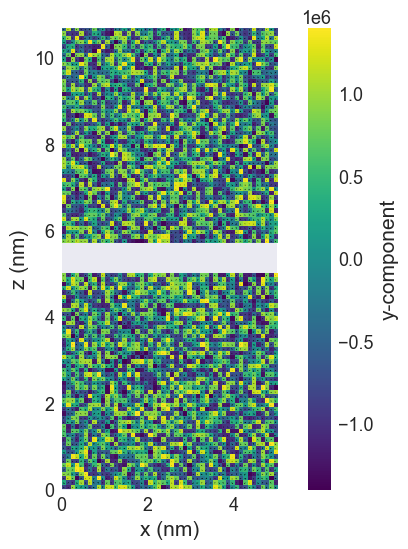

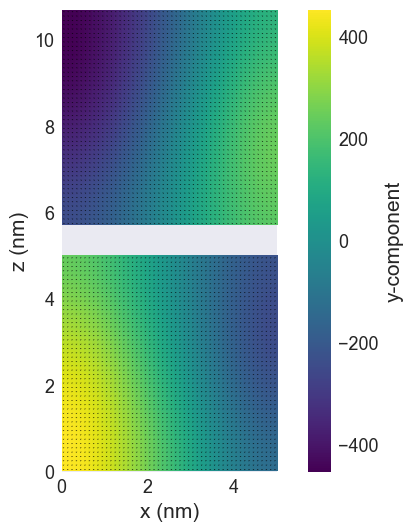

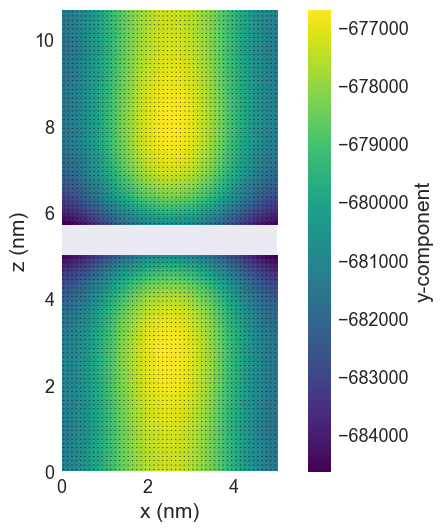

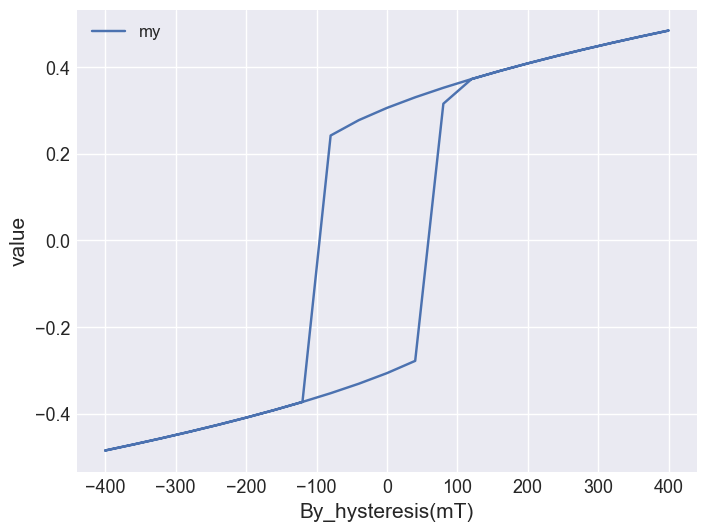

In [50]:
#Funcion para una region de 3 capas
def region(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,celda=0.1e-9):  
    
    #Para la region 1
    xmin1=xminr
    ymin1=yminr
    zmin1=zminr

    zmax1=espesor_ferromagnetico
    
    #Para la region 2
    xmin2=xminr
    ymin2=yminr
    zmin2=zmax1 
    
    
    zmax2=zmin2 + espesor_no_magnetico
    
     #Para la region 3
    
    xmin3=xminr
    ymin3=yminr
    zmin3=zmax2
    
    
    zmax3=zmin3 + espesor_ferromagnetico
    zmaxr=zmax3
    
    xmaxr=5e-9
    ymaxr=5e-9
    
    #R1
    xmax1=xmaxr
    ymax1=ymaxr
     
     #R2
    xmax2=xmaxr
    ymax2=ymaxr
     
     #R3
    xmax3=xmaxr
    ymax3=ymaxr
    
    #defino una lista vacia para las subregiones
    subregions={}
    
    #Creo cada una de las subregiones
    subregions=subreg(xmin1,xmax1,ymin1,ymax1,zmin1,zmax1,subregions,1)
    
    subregions=subreg(xmin2,xmax2,ymin2,ymax2,zmin2,zmax2,subregions,2)
    
    subregions=subreg(xmin3,xmax3,ymin3,ymax3,zmin3,zmax3,subregions,3)
    
    cell=(celda,celda,celda)
    
    #Creo el mesh
    mesh = df.Mesh(p1=(xminr, yminr, zminr), p2=(xmaxr, ymaxr, zmaxr),cell=cell, subregions=subregions)
   
    return mesh,subregions


espesor_no_magnetico=0.7e-9
system10=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system10.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system10,'0_7')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/29 10:07]... (24.6 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/29 10:07]... (116.3 s)


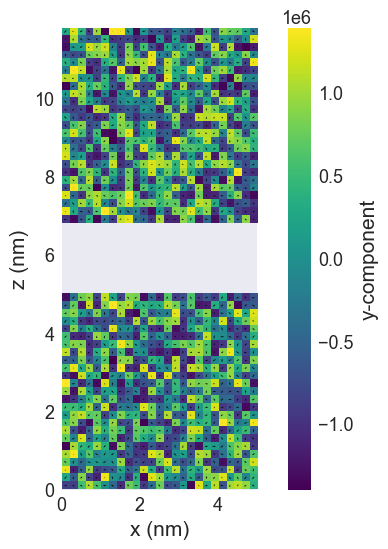

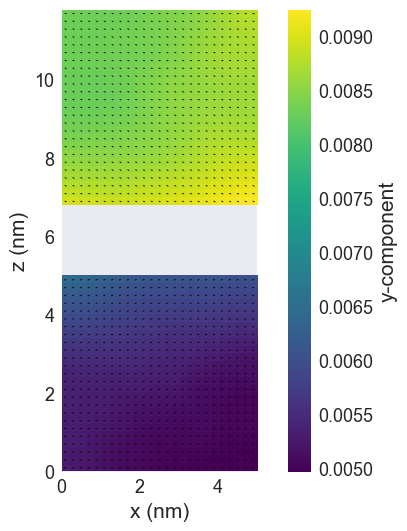

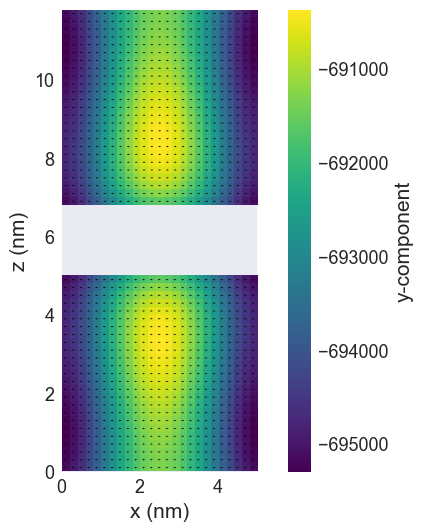

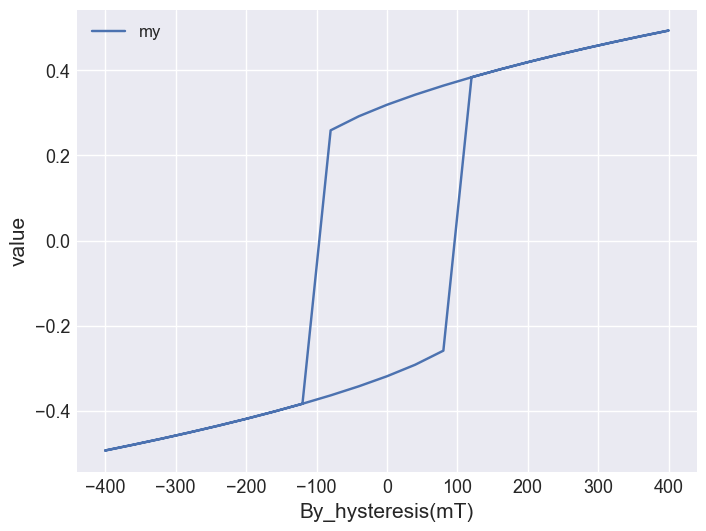

In [52]:
#Funcion para una region de 3 capas
def region(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,celda=0.2e-9):  
    
    #Para la region 1
    xmin1=xminr
    ymin1=yminr
    zmin1=zminr

    zmax1=espesor_ferromagnetico
    
    #Para la region 2
    xmin2=xminr
    ymin2=yminr
    zmin2=zmax1 
    
    
    zmax2=zmin2 + espesor_no_magnetico
    
     #Para la region 3
    
    xmin3=xminr
    ymin3=yminr
    zmin3=zmax2
    
    
    zmax3=zmin3 + espesor_ferromagnetico
    zmaxr=zmax3
    
    xmaxr=5e-9
    ymaxr=5e-9
    
    #R1
    xmax1=xmaxr
    ymax1=ymaxr
     
     #R2
    xmax2=xmaxr
    ymax2=ymaxr
     
     #R3
    xmax3=xmaxr
    ymax3=ymaxr
    
    #defino una lista vacia para las subregiones
    subregions={}
    
    #Creo cada una de las subregiones
    subregions=subreg(xmin1,xmax1,ymin1,ymax1,zmin1,zmax1,subregions,1)
    
    subregions=subreg(xmin2,xmax2,ymin2,ymax2,zmin2,zmax2,subregions,2)
    
    subregions=subreg(xmin3,xmax3,ymin3,ymax3,zmin3,zmax3,subregions,3)
    
    cell=(celda,celda,celda)
    
    #Creo el mesh
    mesh = df.Mesh(p1=(xminr, yminr, zminr), p2=(xmaxr, ymaxr, zmaxr),cell=cell, subregions=subregions)
   
    return mesh,subregions


espesor_no_magnetico=1.8e-9
system11=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system11.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system11,'1_8')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/29 10:09]... (432.3 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/29 10:16]... (10386.6 s)


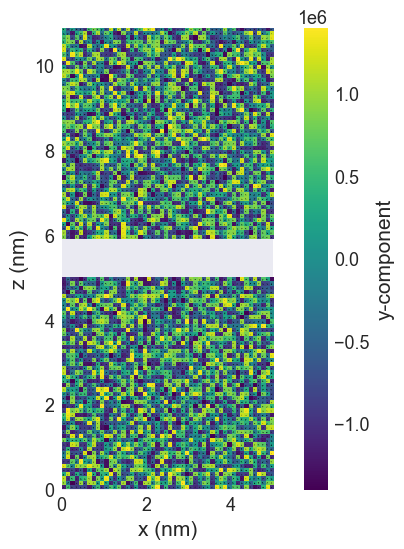

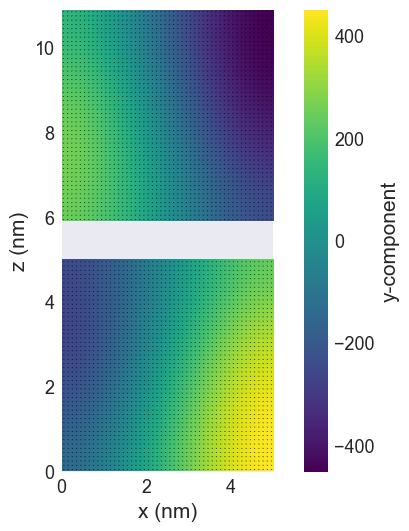

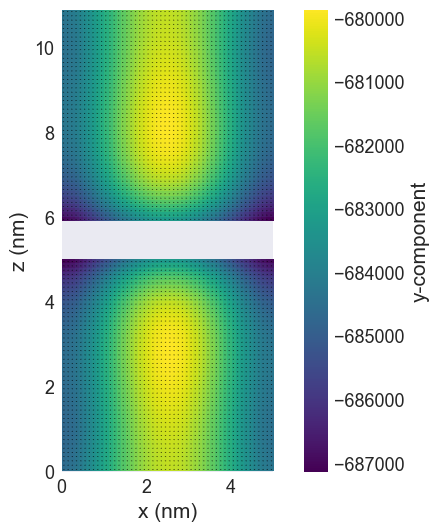

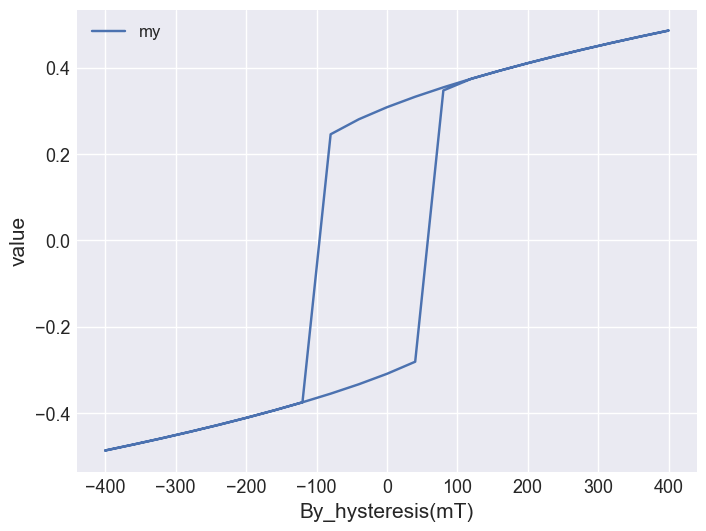

In [53]:
#Funcion para una region de 3 capas
def region(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,celda=0.1e-9):  
    
    #Para la region 1
    xmin1=xminr
    ymin1=yminr
    zmin1=zminr

    zmax1=espesor_ferromagnetico
    
    #Para la region 2
    xmin2=xminr
    ymin2=yminr
    zmin2=zmax1 
    
    
    zmax2=zmin2 + espesor_no_magnetico
    
     #Para la region 3
    
    xmin3=xminr
    ymin3=yminr
    zmin3=zmax2
    
    
    zmax3=zmin3 + espesor_ferromagnetico
    zmaxr=zmax3
    
    xmaxr=5e-9
    ymaxr=5e-9
    
    #R1
    xmax1=xmaxr
    ymax1=ymaxr
     
     #R2
    xmax2=xmaxr
    ymax2=ymaxr
     
     #R3
    xmax3=xmaxr
    ymax3=ymaxr
    
    #defino una lista vacia para las subregiones
    subregions={}
    
    #Creo cada una de las subregiones
    subregions=subreg(xmin1,xmax1,ymin1,ymax1,zmin1,zmax1,subregions,1)
    
    subregions=subreg(xmin2,xmax2,ymin2,ymax2,zmin2,zmax2,subregions,2)
    
    subregions=subreg(xmin3,xmax3,ymin3,ymax3,zmin3,zmax3,subregions,3)
    
    cell=(celda,celda,celda)
    
    #Creo el mesh
    mesh = df.Mesh(p1=(xminr, yminr, zminr), p2=(xmaxr, ymaxr, zmaxr),cell=cell, subregions=subregions)
   
    return mesh,subregions


espesor_no_magnetico=0.9e-9
system12=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system12.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system12,'0_9')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/29 18:40]... (725.0 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/29 18:52]... (5283.7 s)


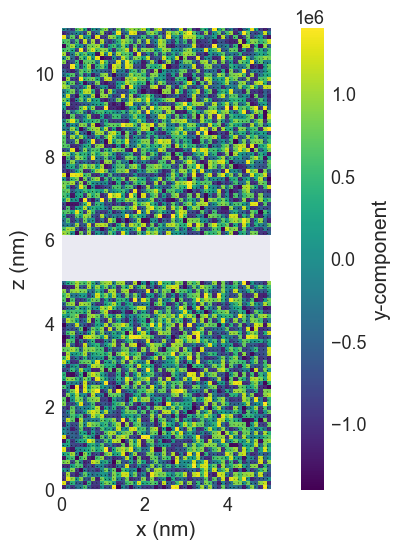

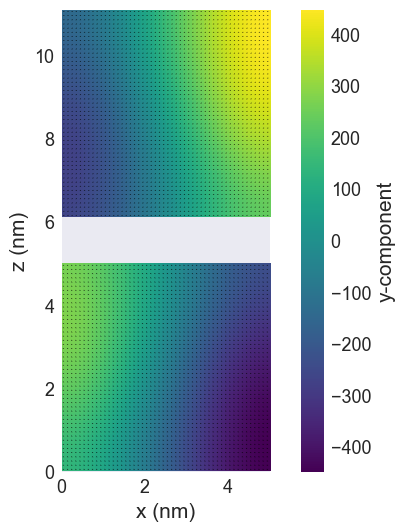

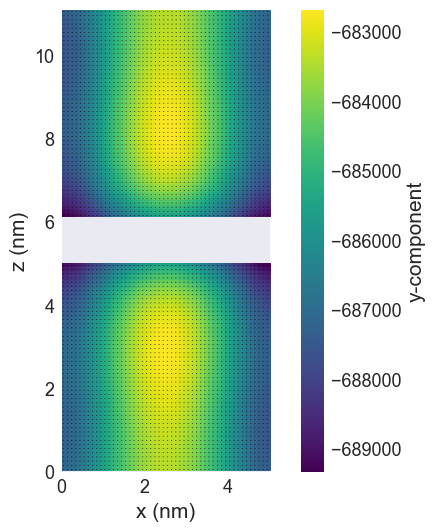

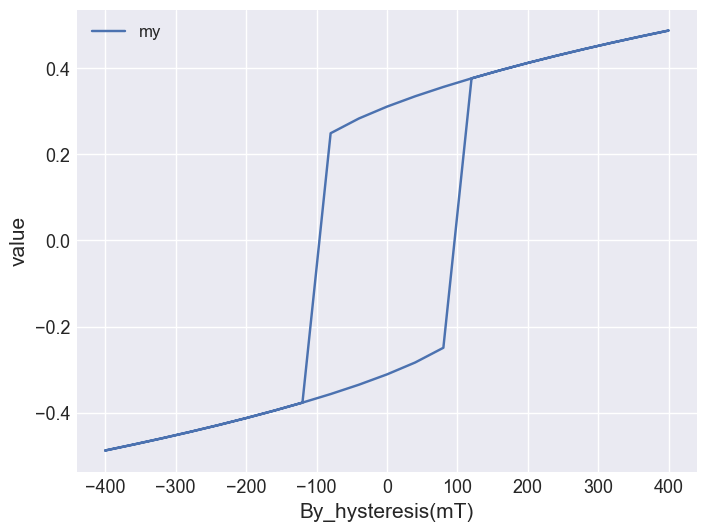

In [54]:

espesor_no_magnetico=1.1e-9
system13=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system13.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system13,'1_1')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/29 20:21]... (554.9 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/29 20:30]... (4664.5 s)


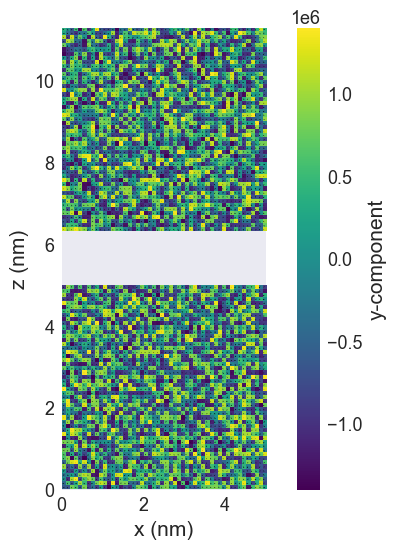

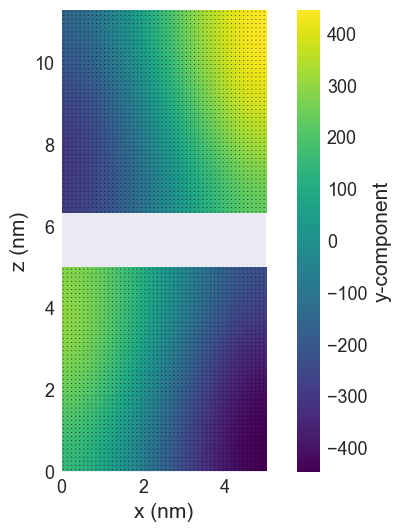

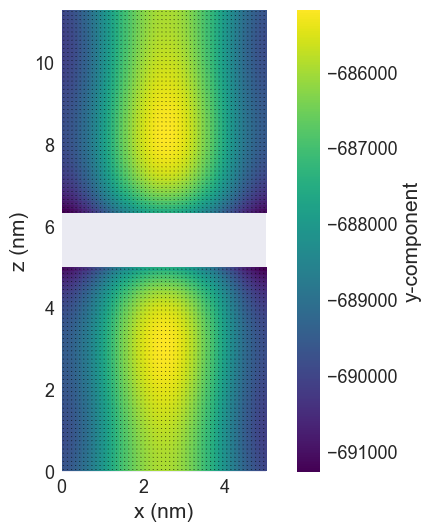

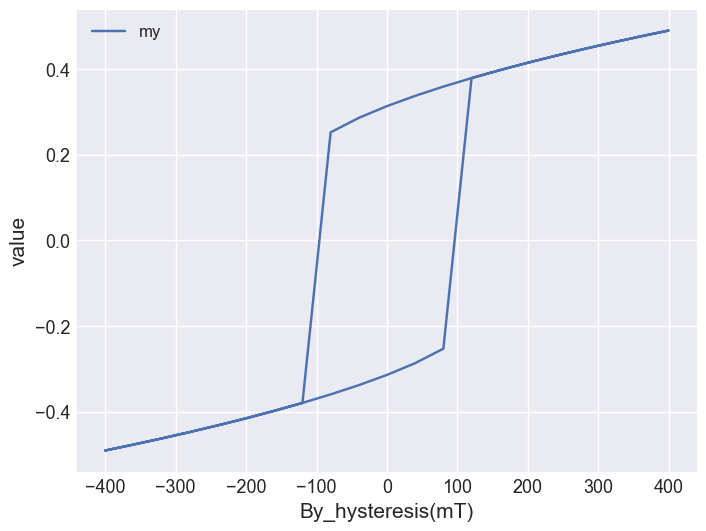

In [55]:

espesor_no_magnetico=1.3e-9
system15=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system15.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system15,'1_3')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/29 21:49]... (555.5 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/29 21:58]... (4582.4 s)


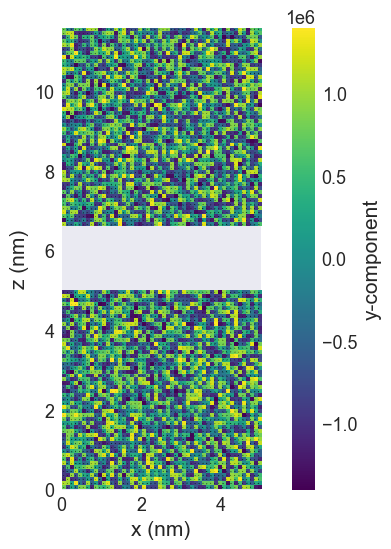

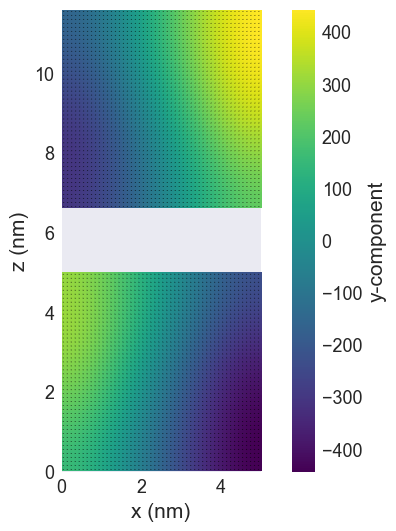

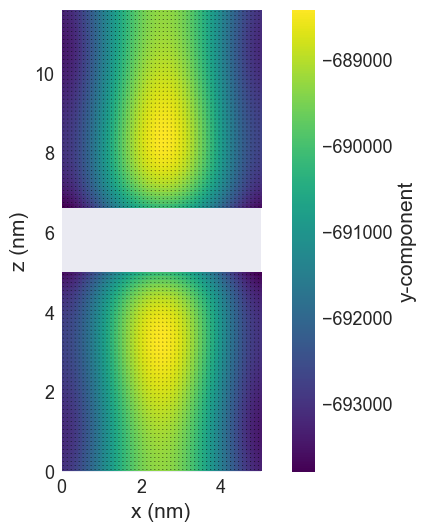

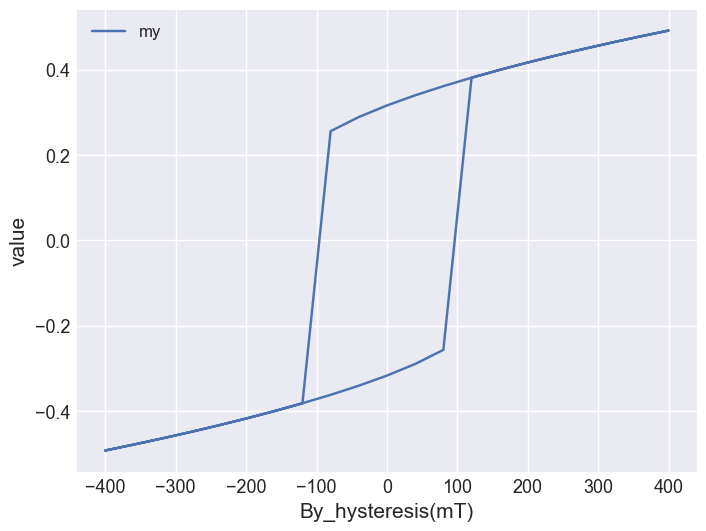

In [56]:

espesor_no_magnetico=1.6e-9
system16=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system16.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system16,'1_6')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/29 23:15]... (562.2 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/29 23:24]... (4639.4 s)


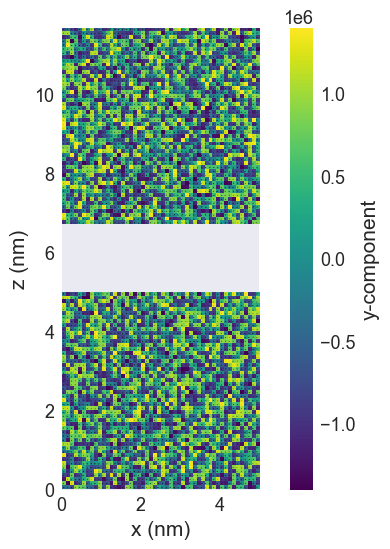

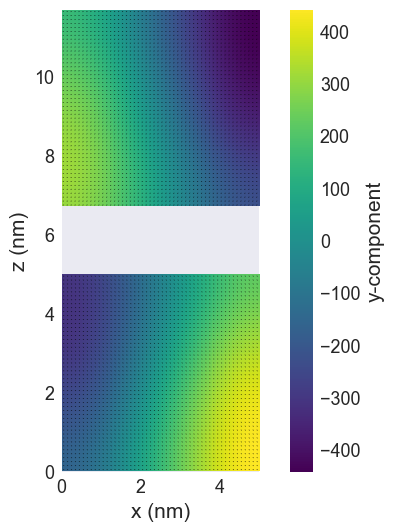

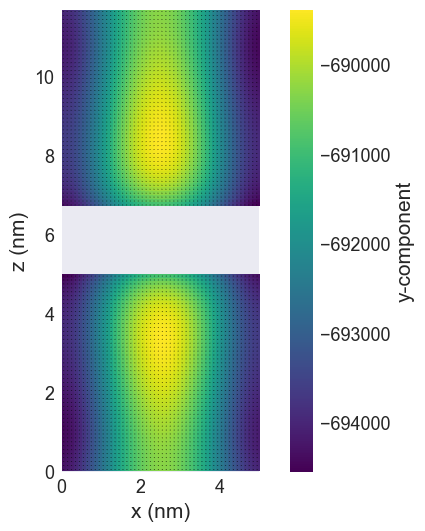

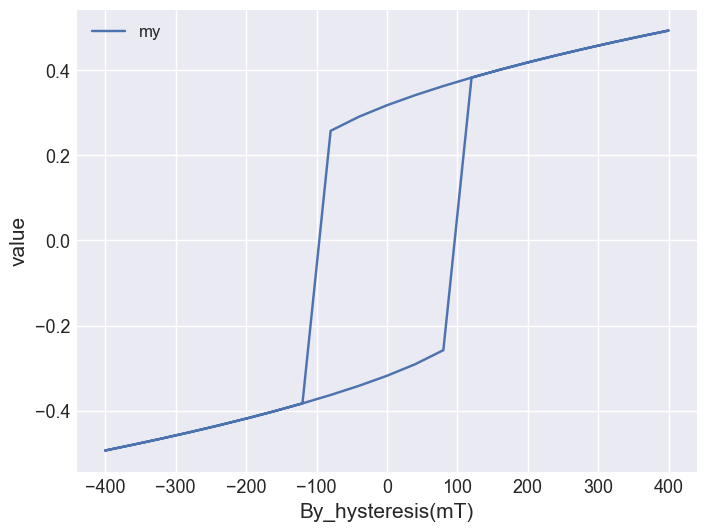

In [57]:

espesor_no_magnetico=1.7e-9
system17=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system17.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system17,'1_7')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/30 00:41]... (532.3 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/30 00:50]... (5123.0 s)


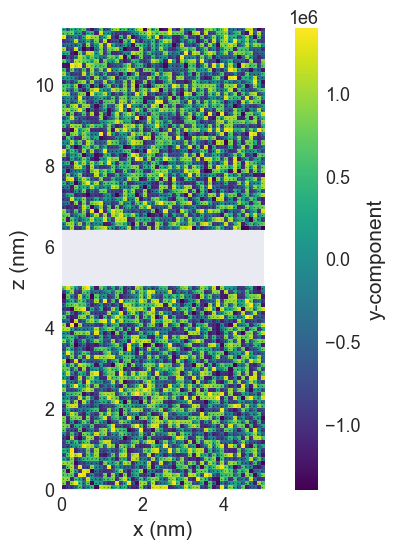

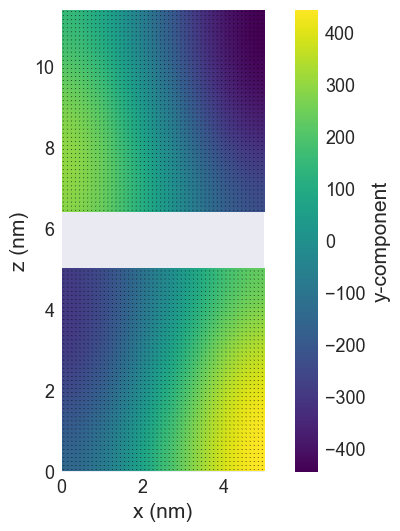

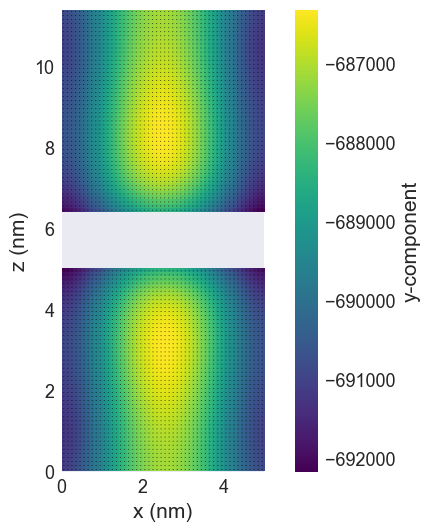

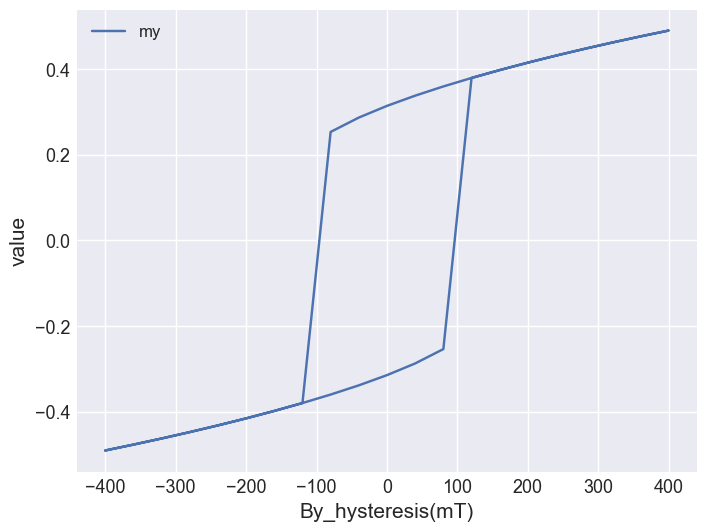

In [58]:

espesor_no_magnetico=1.4e-9
system14=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system14.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system14,'1_4')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/30 02:16]... (22.0 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/30 02:16]... (86.9 s)


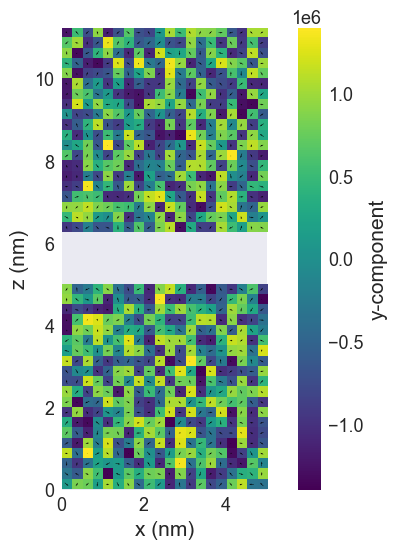

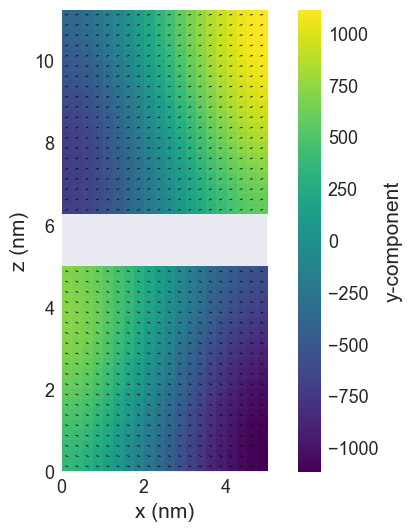

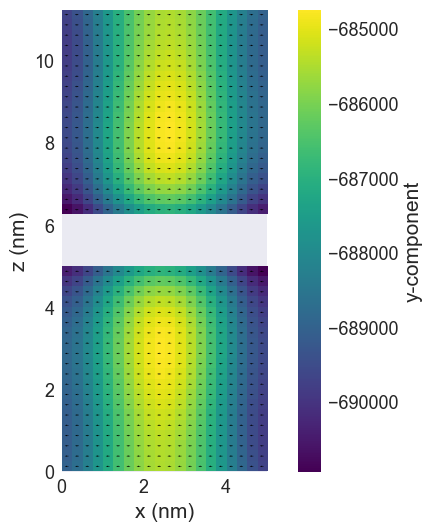

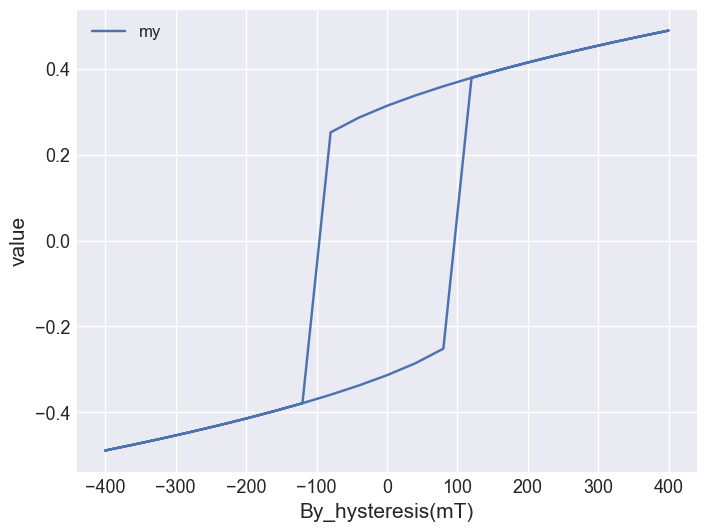

In [59]:
#Funcion para una region de 3 capas
def region(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,celda=0.25e-9):  
    
    #Para la region 1
    xmin1=xminr
    ymin1=yminr
    zmin1=zminr

    zmax1=espesor_ferromagnetico
    
    #Para la region 2
    xmin2=xminr
    ymin2=yminr
    zmin2=zmax1 
    
    
    zmax2=zmin2 + espesor_no_magnetico
    
     #Para la region 3
    
    xmin3=xminr
    ymin3=yminr
    zmin3=zmax2
    
    
    zmax3=zmin3 + espesor_ferromagnetico
    zmaxr=zmax3
    
    xmaxr=5e-9
    ymaxr=5e-9
    
    #R1
    xmax1=xmaxr
    ymax1=ymaxr
     
     #R2
    xmax2=xmaxr
    ymax2=ymaxr
     
     #R3
    xmax3=xmaxr
    ymax3=ymaxr
    
    #defino una lista vacia para las subregiones
    subregions={}
    
    #Creo cada una de las subregiones
    subregions=subreg(xmin1,xmax1,ymin1,ymax1,zmin1,zmax1,subregions,1)
    
    subregions=subreg(xmin2,xmax2,ymin2,ymax2,zmin2,zmax2,subregions,2)
    
    subregions=subreg(xmin3,xmax3,ymin3,ymax3,zmin3,zmax3,subregions,3)
    
    cell=(celda,celda,celda)
    
    #Creo el mesh
    mesh = df.Mesh(p1=(xminr, yminr, zminr), p2=(xmaxr, ymaxr, zmaxr),cell=cell, subregions=subregions)
   
    return mesh,subregions

espesor_no_magnetico=1.25e-9
system15=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system15.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system15,'1_25')

antes
Running OOMMF (ExeOOMMFRunner)[2022/11/30 02:38]... (687.5 s)
después
voy 2
Running OOMMF (ExeOOMMFRunner)[2022/11/30 02:49]... (4740.0 s)


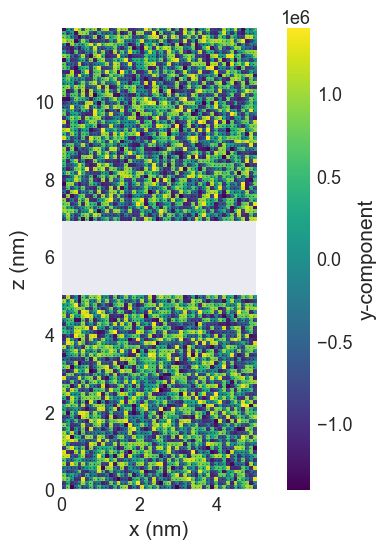

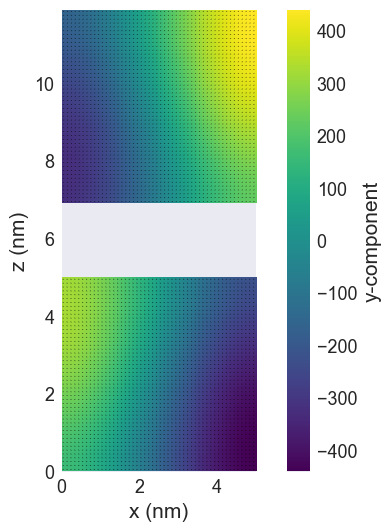

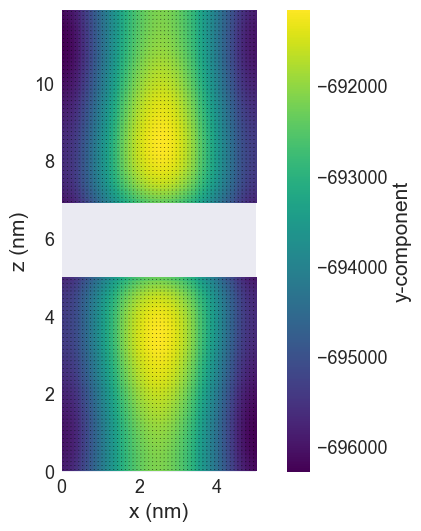

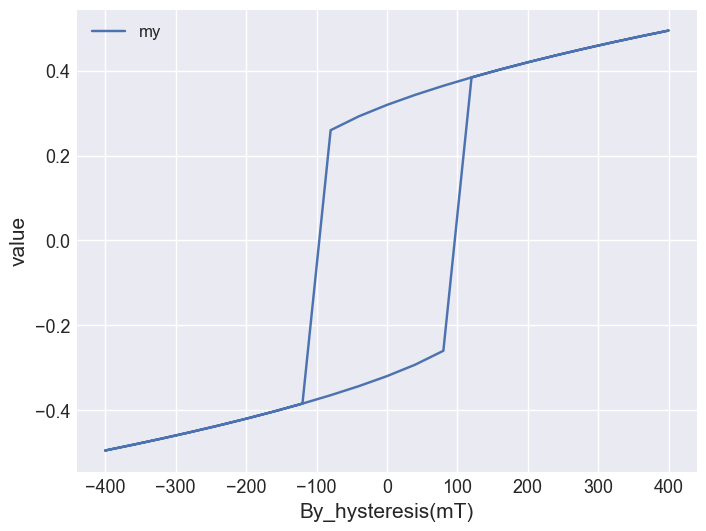

In [60]:
#Funcion para una region de 3 capas
def region(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,celda=0.1e-9):  
    
    #Para la region 1
    xmin1=xminr
    ymin1=yminr
    zmin1=zminr

    zmax1=espesor_ferromagnetico
    
    #Para la region 2
    xmin2=xminr
    ymin2=yminr
    zmin2=zmax1 
    
    
    zmax2=zmin2 + espesor_no_magnetico
    
     #Para la region 3
    
    xmin3=xminr
    ymin3=yminr
    zmin3=zmax2
    
    
    zmax3=zmin3 + espesor_ferromagnetico
    zmaxr=zmax3
    
    xmaxr=5e-9
    ymaxr=5e-9
    
    #R1
    xmax1=xmaxr
    ymax1=ymaxr
     
     #R2
    xmax2=xmaxr
    ymax2=ymaxr
     
     #R3
    xmax3=xmaxr
    ymax3=ymaxr
    
    #defino una lista vacia para las subregiones
    subregions={}
    
    #Creo cada una de las subregiones
    subregions=subreg(xmin1,xmax1,ymin1,ymax1,zmin1,zmax1,subregions,1)
    
    subregions=subreg(xmin2,xmax2,ymin2,ymax2,zmin2,zmax2,subregions,2)
    
    subregions=subreg(xmin3,xmax3,ymin3,ymax3,zmin3,zmax3,subregions,3)
    
    cell=(celda,celda,celda)
    
    #Creo el mesh
    mesh = df.Mesh(p1=(xminr, yminr, zminr), p2=(xmaxr, ymaxr, zmaxr),cell=cell, subregions=subregions)
   
    return mesh,subregions

espesor_no_magnetico=1.9e-9
system19=grafica_histeresis(xminr,yminr,zminr, espesor_ferromagnetico, espesor_no_magnetico,A,K,sigma,sigma2,Ms,campo_aplicado)
system19.table.mpl(x='By_hysteresis', y=['my'])
guardar_datos(system19,'1_9')